# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [4]:
matrix = np.zeros([28,28])
new = np.pad(matrix, (1,1), mode='constant', constant_values=0)
new.shape

(30, 30)

In [5]:
# Defining a Gaussian Blur function for each number in the data set
def gaussian_blur(data):
    # Reshape into a matrix
    data = data.reshape(28,28)
    
    # Pad the matrix so we don't have to deal with "edge cases"
    data = np.pad(data, (1,1), mode='constant', constant_values=0)
    
    
    blurred_data = np.zeros([30,30])
    # Choose an arbitrary weight?????????????
    weight = 100
    
    for row in range(len(data)-1):
        # skip edge rows filled with zeros
        if (row == 0) or (row == len(data)-1):
            pass
        
        for col in range(len(data[row])-2):
            # skip edge columns filled with zeros
            if (col == 0) or (col == len(data[row])-1):
                pass
            
            # Find the 8 neighbors used to find the new value and multiply by the chosen weight
            nbr1 = data[row-1][col-1] * weight
            nbr2 = data[row-1][col] * weight
            nbr3 = data[row-1][col+1] * weight
            nbr4 = data[row][col-1] * weight
            nbr5 = data[row][col+1] * weight
            nbr6 = data[row+1][col-1] * weight
            nbr7 = data[row+1][col] * weight
            nbr8 = data[row+1][col+1] * weight
            nbr_lst = [nbr1,nbr2,nbr3,nbr4,nbr5,nbr6,nbr7,nbr8]
            avg = sum(nbr_lst)/8
            
            # Populate the new blurred data matrix with the average computed using the 8 nearest neighbors
            blurred_data[row][col] = avg
            
    blurred_data = np.delete(blurred_data, 0, axis=1)
    blurred_data = np.delete(blurred_data, 0, axis=0)        
    blurred_data = np.delete(blurred_data, len(matrix)-1, axis=1)
    blurred_data = np.delete(blurred_data, len(matrix)-1, axis=0)
    
    return blurred_data

def Q1():
    # First model does not use the filter
    model1 = KNeighborsClassifier(n_neighbors=1)
    model1.fit(mini_train_data, mini_train_labels)
    accuracy1 = model1.score(dev_data, dev_labels)
    print("The accuracy of 1-Nearest Neighbor Model with no filter applied: ", accuracy1)
    
    # Second model will filter the training data but not the dev data 
    blurred_mini_train_data = []
    for num in mini_train_data:
        new_num = gaussian_blur(num).reshape(784,)
        blurred_mini_train_data.append(new_num)
    blurred_mini_train_data = np.array(blurred_mini_train_data)
    
    model2= KNeighborsClassifier(n_neighbors=1)
    model2.fit(blurred_mini_train_data, mini_train_labels)
    accuracy2= model2.score(dev_data, dev_labels)
    print("The accuracy of 1-Nearest Neighbor Model with only filtered train data: ", accuracy2)
    
   # Third model will filter the dev data but not the training data
    blurred_dev_data = []
    for num in dev_data:
        new_num = gaussian_blur(num).reshape(784,)
        blurred_dev_data.append(new_num)
    blurred_dev_data = np.array(blurred_dev_data)
    
    model3= KNeighborsClassifier(n_neighbors=1)
    model3.fit(mini_train_data, mini_train_labels)
    accuracy3= model3.score(blurred_dev_data, dev_labels)
    print("The accuracy of 1-Nearest Neighbor Model with only filtered dev data: ", accuracy3)
    
    # Fourth model filters both training and dev data
    model4= KNeighborsClassifier(n_neighbors=1)
    model4.fit(blurred_mini_train_data, mini_train_labels)
    accuracy4= model3.score(blurred_dev_data, dev_labels)
    print("The accuracy of 1-Nearest Neighbor Model with both filtered dev data and training data: ", accuracy4)

Q1()

The accuracy of 1-Nearest Neighbor Model with no filter applied:  0.884
The accuracy of 1-Nearest Neighbor Model with only filtered train data:  0.118
The accuracy of 1-Nearest Neighbor Model with only filtered dev data:  0.515
The accuracy of 1-Nearest Neighbor Model with both filtered dev data and training data:  0.515


In [6]:
# Defining a gaussian blur function for each number in the data set
def gaussian_blur(data):
    # Reshape number into a matrix
    data = data.reshape(28,28)
    
    # Pad the matrix so we don't have to deal with "edge cases"
    data = np.pad(data, (1,1), mode='constant', constant_values=0)
    
    blurred_data = np.zeros([30,30])
    # Chose an arbitrary weight 
    weight = 100
    
    for row in range(len(data)-1):
        # skip edge rows filled with 0s
        if (row == 0) or (row == len(data)-1):
            pass
        
        for col in range(len(data[row])-2):
            # skip edge columns filled with 0s
            if (col == 0) or (col == len(data[row])-1):
                pass
            
            # Find the 8 neighbors used to compute the new value and multiply by the weight chosen
            nbr1 = data[row-1][col-1] * weight
            nbr2 = data[row-1][col] * weight
            nbr3 = data[row-1][col+1] * weight
            nbr4 = data[row][col-1] * weight
            nbr5 = data[row][col+1] * weight
            nbr6 = data[row+1][col-1] * weight
            nbr7 = data[row+1][col] * weight
            nbr8 = data[row+1][col+1] * weight
            nbr_lst = [nbr1, nbr2, nbr3, nbr4, nbr5, nbr6, nbr7, nbr8]
            avg = sum(nbr_lst) / 8
            
            # populate new blurred data matrix with the average computed using the 8 nearest neighbors
            blurred_data[row][col] = avg
            
    # Remove 0s used for padding 
    blurred_data = np.delete(blurred_data, 0, axis=1)
    blurred_data = np.delete(blurred_data, 0, axis=0)
    blurred_data = np.delete(blurred_data, len(blurred_data)-1, axis=1)
    blurred_data = np.delete(blurred_data, len(blurred_data)-1, axis=0)
    
    return blurred_data
    

def Q1():
    
    # First model does not use the filter
    model1 = KNeighborsClassifier(n_neighbors = 1)
    model1.fit(mini_train_data, mini_train_labels)
    accuracy1 = model1.score(dev_data, dev_labels)
    print("Accuracy of 1-Nearest Neighbor Model With No Filter Applied:", accuracy1)
    
    # Second model will filter the training data but not the dev data
    blurred_mini_train_data = []
    for num in mini_train_data:
        new_num = gaussian_blur(num).reshape(784,)
        blurred_mini_train_data.append(new_num)  
    blurred_mini_train_data = np.array(blurred_mini_train_data) 
    
    model2 = KNeighborsClassifier(n_neighbors = 1)
    model2.fit(blurred_mini_train_data, mini_train_labels)
    accuracy2 = model2.score(dev_data, dev_labels)
    print("Accuracy of 1-Nearest Neighbor Model With Filtered Train Data Only:", accuracy2)

    # Third model will filter the dev data but not the training data
    blurred_dev_data = []
    for num in dev_data:
        new_num = gaussian_blur(num).reshape(784,)
        blurred_dev_data.append(new_num)  
    blurred_dev_data = np.array(blurred_dev_data) 
    
    model3 = KNeighborsClassifier(n_neighbors = 1)
    model3.fit(mini_train_data, mini_train_labels)
    accuracy3 = model3.score(blurred_dev_data, dev_labels)
    print("Accuracy of 1-Nearest Neighbor Model With Filtered Dev Data Only:", accuracy3)
    
    # Fourth model will filter both the training and dev data
    model4 = KNeighborsClassifier(n_neighbors = 1)
    model4.fit(blurred_mini_train_data, mini_train_labels)
    accuracy4 = model4.score(blurred_dev_data, dev_labels)
    print("Accuracy of 1-Nearest Neighbor Model With Filtered Train & Dev Data:", accuracy4)

Q1()

Accuracy of 1-Nearest Neighbor Model With No Filter Applied: 0.884
Accuracy of 1-Nearest Neighbor Model With Filtered Train Data Only: 0.118
Accuracy of 1-Nearest Neighbor Model With Filtered Dev Data Only: 0.516
Accuracy of 1-Nearest Neighbor Model With Filtered Train & Dev Data: 0.904


## Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
### We see that the accuracy of the models that only have either the train or dev data filtered are really bad. This makes sense since training only on blurry data will not produce a model that can generalize well to non-blurry data. Similarly, if we train on non-blurry data and then test the model using blurry data, the model is not likely to perform well. The top two accuracies belong to the models with either no filter applied or the filter applied to both the training and dev data. Since we are training and testing the model with similar data this is expected. I was surprised that the best accuracy belonged to the model that filtered both the train and dev data. This shows that applying a smoothing technique to blur images may actually result in a better model than using the original pixels.

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [7]:
# Solution with binarization by explicit binarize function
def trinarize(data):
    new_data = []
    for pixel in data:
        if pixel < 0.1:
            new_data.append(0) # data point is classified as white
        elif pixel >= 0.1 and pixel <= 0.9:
            new_data.append(0) # data point is classified as gray
        else:
            new_data.append(2) # data point is classified as black
    return np.array(new_data).reshape(784,)
            


def Q2():

    # First model will represent pixel value as either white or black
    model1 = BernoulliNB(binarize=0.1)
    model1.fit(mini_train_data, mini_train_labels)
    accuracy1= model1.score(dev_data, dev_labels)
    print("Accuracy of BinomialNB Classifier: ", accuracy1)

     # First model will represent pixel value as either white or black
    model2 = MultinomialNB()
    trinarized_data = []
    # pre-processes the data set white/gray/black separation thresholds to 0.1 and 0.9
    for num in mini_train_data:
        new_num = trinarize(num)
        trinarized_data.append(new_num)
    trinarized_data = np.array(trinarized_data)
    model2.fit(trinarized_data, mini_train_labels)
    accuracy2 = model2.score(dev_data, dev_labels)
    print("Accuracy of MultinomialNB Classifier: ", accuracy2)

Q2()

Accuracy of BinomialNB Classifier:  0.814
Accuracy of MultinomialNB Classifier:  0.811


## Does the multinomial version improve the results? Why or why not?

### The multinomial version does not improve the results. I belive this is due to the introduction of an addional classifaction category (i.e. addition of the gray classifier). The presece of the third classifier, opens up room for misclassification errors related to the nuances of color along the separation thresholds set in this instance.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [8]:
def Q3(alphas):
    
    grid_search = GridSearchCV(BernoulliNB(binarize=0), param_grid=alphas, n_jobs=-1, cv=5, scoring='accuracy')
    grid_search.fit(mini_train_data, mini_train_labels)
    
    print("Accuracy at each alpha value: ")

    cv1 = grid_search.cv_results_['split0_test_score']
    cv2 = grid_search.cv_results_['split1_test_score']
    cv3 = grid_search.cv_results_['split2_test_score']
    cv4 = grid_search.cv_results_['split3_test_score']
    cv5 = grid_search.cv_results_['split4_test_score']

    
    for idx in range(len(alphas['alpha'])):
        avg = (cv1[idx] + cv2[idx] + cv3[idx] + cv4[idx] + cv5[idx])/5
        print("Accuracy for alpha equal to", alphas['alpha'][idx], "is: ", round(avg, 3))
        
        
    print('')
    print("The best value for alpha: ", grid_search.best_params_)



alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Accuracy at each alpha value: 
Accuracy for alpha equal to 1e-10 is:  0.814
Accuracy for alpha equal to 0.0001 is:  0.819
Accuracy for alpha equal to 0.001 is:  0.825
Accuracy for alpha equal to 0.01 is:  0.822
Accuracy for alpha equal to 0.1 is:  0.818
Accuracy for alpha equal to 0.5 is:  0.813
Accuracy for alpha equal to 1.0 is:  0.809
Accuracy for alpha equal to 2.0 is:  0.805
Accuracy for alpha equal to 10.0 is:  0.783

The best value for alpha:  {'alpha': 0.001}


## What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?
### As alpha approaches zero, its accuracy increases. The inverse is also true. The training data in this instance is rather large, so I expected this to be the case.


### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [9]:
def Q4():
    
    model1 = GaussianNB()
    model1.fit(mini_train_data, mini_train_labels)
    accuracy1 = model1.score(dev_data, dev_labels)
    print("The Accuracy For The First Model:",accuracy1)
    
    model2 = GaussianNB(var_smoothing=0.1)
    model2.fit(mini_train_data, mini_train_labels)
    accuracy2 = model2.score(dev_data, dev_labels)
    print("The Accuracy For The Second (Fixed) Model:",accuracy2)


Q4()

The Accuracy For The First Model: 0.593
The Accuracy For The Second (Fixed) Model: 0.817


## Diagnose and explain the problem
### In this instance, the Gaussian smoothing algorithm isn't as accurate as the Bernoulli Naive Bayes model because Gaussian smoothing is meant to be used when all our features are continuous. However, we're attempting to our data points as 'white', 'gray', or 'black' in this instance, and these features are discrete in nature. The accuracy issues from the Gaussian model are due to the improper utilization of the algorithm on a data set more suited towards Multinomial or Bernoulli methods for improved accuracy. 

## Explain your solution
### The variable, var_smoothing, artificially adds a user-defined value to the distribution's variance (whose default value is derived from the training data set). This essentially widens (or "smooths") the curve and accounts for more samples that are further away from the distribution mean.

ANSWER: 

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



Plot Of 10 Examples Of Each Digit:


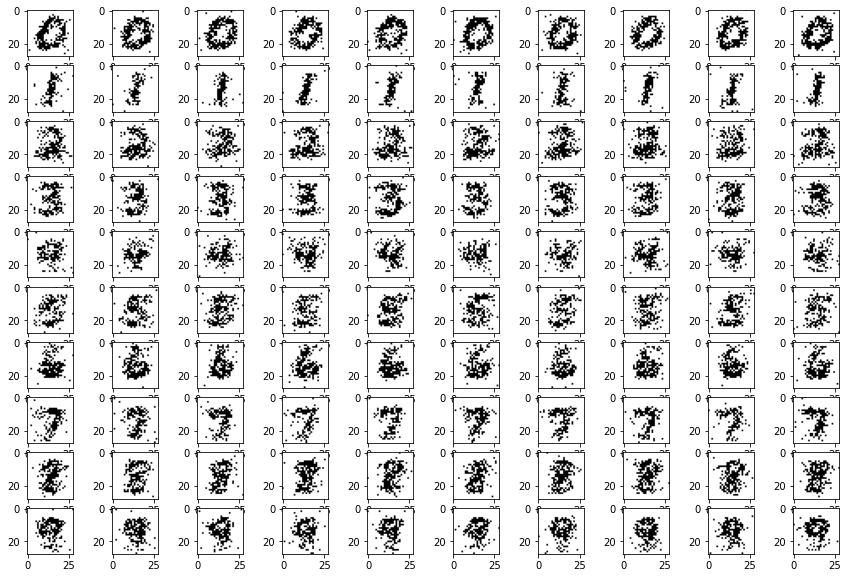

In [10]:
def create_grid(data):
    plt.figure(figsize=(15,10))
    counter = 1
    
    # find 10 examples of each digit
    print("Plot Of 10 Examples Of Each Digit:")
    for i in range(100):
        plt.subplot(10, 10, counter)
        y = np.array(data[i]).reshape(28,28)
        plt.imshow(y, cmap=plt.get_cmap('gray_r'))
        counter += 1
            
def Q5(num_examples):

    model = BernoulliNB(binarize=0.1)
    model.fit(mini_train_data, mini_train_labels)
    feature_prob = np.exp(model.feature_log_prob_)
    random_digits = []
    for i in range(len(feature_prob)):
        counter = 0
        while counter < 10:
            temp = []
            for j in range(len(feature_prob[i])):
                if np.random.rand() <= feature_prob[i][j]:
                    temp.append(1)
                else:
                    temp.append(0)
            random_digits.append(temp)            
            counter += 1

    random_digits = np.array(random_digits)
    create_grid(random_digits)
    
    

Q5(10)

## How do the generated digit images compare to the training digit images?
### The generated digit images are more sparce, essentially more "blurred", than the training digit images. 


### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [13]:
def Q6(buckets, correct, total):
    
    model = BernoulliNB(binarize=0, alpha=0.001)
    model.fit(mini_train_data, mini_train_labels)
    
    prob_predicted_classes = model.predict_proba(dev_data)
    
    for i in range(len(prob_predicted_classes)):
        est_posterior_prob = max(prob_predicted_classes[i])
        idx = int(np.where(prob_predicted_classes[i] == est_posterior_prob)[0][0])
        correct_class = int(dev_labels[i])
        
        if est_posterior_prob <= buckets[0]:
            total[0] += 1
            
            if correct_class == idx:
                correct[0] += 1
        
        elif (est_posterior_prob > buckets[0]) & (est_posterior_prob <= buckets[1]):
            total[1] += 1
            
            if correct_class == idx:
                correct[1] += 1
            
        elif (est_posterior_prob > buckets[1]) & (est_posterior_prob <= buckets[2]):
            total[2] += 1
            
            if correct_class == idx:
                correct[2] += 1
            
        elif (est_posterior_prob > buckets[2]) & (est_posterior_prob <= buckets[3]):
            total[3] += 1
            
            if correct_class == idx:
                correct[3] += 1
                
        elif (est_posterior_prob > buckets[3]) & (est_posterior_prob <= buckets[4]):
            total[4] += 1
            
            if correct_class == idx:
                correct[4] += 1
            
        elif (est_posterior_prob > buckets[4]) & (est_posterior_prob <= buckets[5]):
            total[5] += 1
            
            if correct_class == idx:
                correct[5] += 1
        
        elif (est_posterior_prob > buckets[5]) & (est_posterior_prob <= buckets[6]):
            total[6] += 1
            
            if correct_class == idx:
                correct[6] += 1
            
        elif (est_posterior_prob > buckets[6]) & (est_posterior_prob <= buckets[7]):
            total[7] += 1
            
            if correct_class == idx:
                correct[7] += 1
            
        elif (est_posterior_prob > buckets[7]) & (est_posterior_prob <= buckets[8]):
            total[8] += 1
            
            if correct_class == idx:
                correct[8] += 1
    
    for i in range(len(buckets)):
        if total[i] != 0:
            print("For bucket",i+1,"(" + str(buckets[i]) + ") the accuracy is:",correct[i]/total[i])
        else:
            print("There were no records that fell in bucket",i+1, "(" + str(buckets[i]) + ")")
        
    

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

There were no records that fell in bucket 1 (0.5)
For bucket 2 (0.9) the accuracy is: 0.3548387096774194
For bucket 3 (0.999) the accuracy is: 0.43283582089552236
For bucket 4 (0.99999) the accuracy is: 0.4576271186440678
For bucket 5 (0.9999999) the accuracy is: 0.6521739130434783
For bucket 6 (0.999999999) the accuracy is: 0.7741935483870968
For bucket 7 (0.99999999999) the accuracy is: 0.7878787878787878
For bucket 8 (0.9999999999999) the accuracy is: 0.7906976744186046
For bucket 9 (1.0) the accuracy is: 0.9377845220030349


## How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?
### This model can be characterized as weakly calibrated because although it improves its accuracy based on confidence, the model's actual accuracy is still less than 80%.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [12]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()

IndentationError: expected an indented block (<ipython-input-12-57d016c02e77>, line 7)